<a href="https://colab.research.google.com/github/viviakemik/machine-learning/blob/main/statistics/statistical_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Book: https://www.amazon.com.br/Practical-Statistics-Scientists-Peter-Bruce/dp/1491952962

2. Courses

    * https://www.coursera.org/learn/statistics-for-data-science-python
    * https://thecrashcourse.com/courses/statistics
    * https://www.youtube.com/watch?v=qBigTkBLU6g&list=PLblh5JKOoLUK0FLuzwntyYI10UQFUhsY9
    * https://classroom.udacity.com/courses/ud257
    * https://www.youtube.com/channel/UC6AVa0vSrCpuskzGDDKz_EQ

3. https://github.com/gedeck/practical-statistics-for-data-scientists

In [ ]:
%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'drive/MyDrive/Colab Notebooks/Pratical Statistics Data Scientist/data'

In [ ]:
WEB_PAGE_DATA_CSV = 'https://raw.githubusercontent.com/gedeck/practical-statistics-for-data-scientists/master/data/web_page_data.csv'
FOUR_SESSIONS_CSV = 'https://raw.githubusercontent.com/gedeck/practical-statistics-for-data-scientists/master/data/four_sessions.csv'
CLICK_RATE_CSV = 'https://raw.githubusercontent.com/gedeck/practical-statistics-for-data-scientists/master/data/click_rates.csv'
IMANISHI_CSV = 'https://raw.githubusercontent.com/gedeck/practical-statistics-for-data-scientists/master/data/imanishi_data.csv'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


https://www.amazon.com.br/Practical-Statistics-Scientists-Peter-Bruce/dp/1491952962


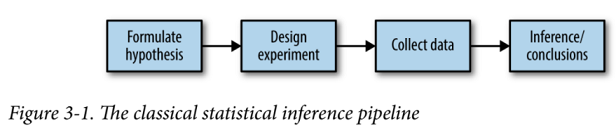

# **A/B Testing**

https://www.youtube.com/watch?v=VuKIN9S8Ivs

# **Hypothesis Tests**

https://www.youtube.com/watch?v=0oc49DyA3hU

https://www.youtube.com/watch?v=zR2QLacylqQ

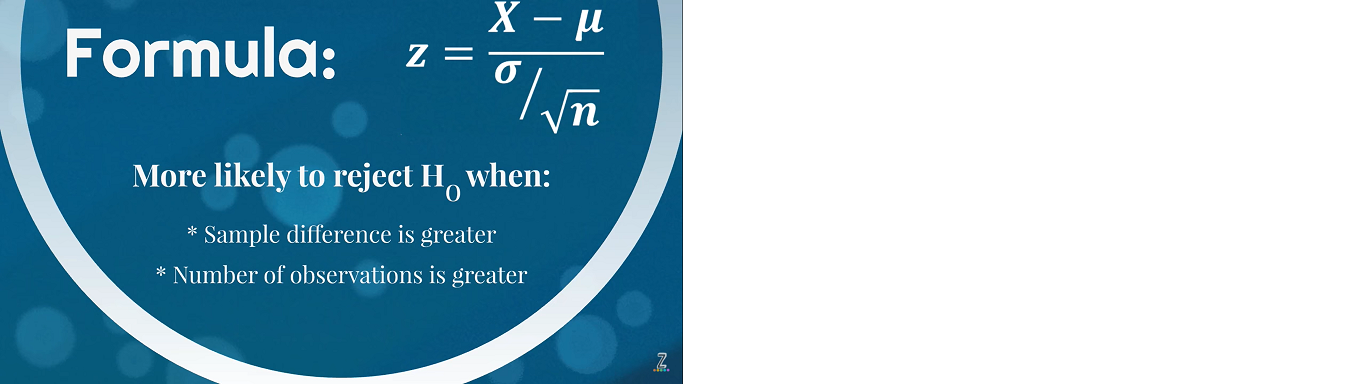

# **Resampling**

Resampling in statistics means to repeatedly sample values from observed data, with a general goal of assessing random variability in a statistic.
* Bootstrap
* Permutation test (combining two or more samples together and randomly)

## **Permutation Test**

In [ ]:
session_times = pd.read_csv(WEB_PAGE_DATA_CSV)
session_times.Time = 100 * session_times.Time

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


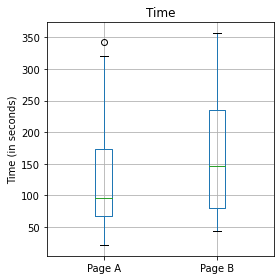

In [ ]:
ax = session_times.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')

plt.tight_layout()
plt.show()

page B leads to longer sessions than page A.

In [ ]:
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
print(mean_b - mean_a)

35.66666666666667


Page B has session times that are greater than those of page A by 35.67 seconds, on average. 

The question is whether this difference is within the range of what random
chance might produce, i.e., is statistically significant.

In [ ]:
# Permutation test example with stickiness
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()
    
nA = session_times[session_times.Page == 'Page A'].shape[0]
nB = session_times[session_times.Page == 'Page B'].shape[0]
print(perm_fun(session_times.Time, nA, nB))

-37.704761904761895


This function works by sampling (without replacement) nB indices and assigning them to the B group; the remaining nA indices are assigned to group A.

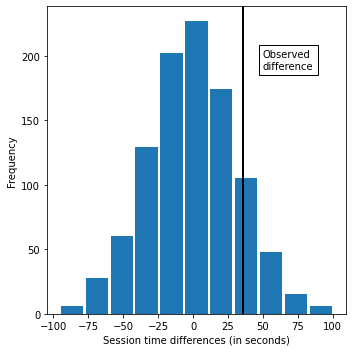

In [ ]:
random.seed(1)
perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = mean_b - mean_a, color='black', lw=2)
ax.text(50, 190, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
(len([val for val in perm_diffs if val > mean_b - mean_a]))/len(perm_diffs)

0.121

This suggests that the observed difference in session time between page A and page B is well within the range of chance variation and thus is not statistically significant.

# **Statistical Significance and p-Values**

Statistical significance is how statisticians measure whether an experiment (or even a study of existing data) yields a result more extreme than what chance might produce.

a statistically significant result (usually a difference) is a result that’s not attributed to chance.

|Outocme   | Price A  | Price B  |   |   |
|---|---|---|---|---|
| Conversion  | 200  | 182  |   |   |
| No conversion  | 23,539  | 22,406  |   |   |
|   |   |   |   |   |

Price A converts almost 5% better than price B

“If the two prices share the same conversion rate, could chance variation produce a difference as big as 5%?”

Observed difference: 0.0368%


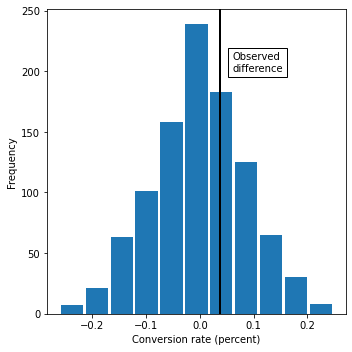

In [ ]:
random.seed(1)
obs_pct_diff = 100 * (200 / 23739 - 182 / 22588)
print(f'Observed difference: {obs_pct_diff:.4f}%')
conversion = [0] * 45945
conversion.extend([1] * 382)
conversion = pd.Series(conversion)

perm_diffs = [100 * perm_fun(conversion, 23739, 22588) 
              for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='black', lw=2)
ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

See the histogram of 1,000 resampled results: as it happens, in this case
the observed difference of 0.0368% is well within the range of chance variation.

Simply looking at the graph is not a very precise way to measure statistical significance, so of more interest is the p-value.

## **p-Value**

This is the frequency with which the chance model produces a result more extreme than the observed result.

* “Given a chance model, what is the probability of a result this extreme?”
* Even if a result is statistically significant, that does not mean it has practical significance.
* does not measure the size of an effect or the importance of a result.
* The probability that the result is due to chance = P-value (WRONG!)

estimate a p-value from our permutation test by taking the proportion of times that the permutation test produces a difference equal to or greater than the observed difference:

In [ ]:
print(np.mean([diff > obs_pct_diff for diff in perm_diffs]))

0.332


which means that we would expect to achieve a result as
extreme as this, or a more extreme result, by random chance over 30% of the time.

If a p-value higher than alpha (> 0.05) is not statistically significant and indicates strong evidence for the null hypothesis.

In [ ]:
survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)

print(f'p-value for single sided test: {p_value / 2:.4f}')

p-value for single sided test: 0.3498


## **Alpha**

A threshold is specified in advance, as in “more extreme than 5% of the chance (null hypothesis) results”; this threshold is known as alpha.

## **Type 1 and Type 2 Errors**

* Type I error: you mistakenly conclude an effect is real, when it is
really just due to chance => reject the true null hypothesis
* Type II error: you mistakenly conclude that an effect is not real (i.e.,
due to chance), when it actually is real => failed to reject a false null hypothesis

| **Null Hypothesis**  | **is True**  | **is False**  |
|:-:|---|---|
| p-value significant  | Type I error  | Correct |
| p-value not-significant  | Correct  |  Type II error |

https://www.abtasty.com/blog/type-1-and-type-2-errors/

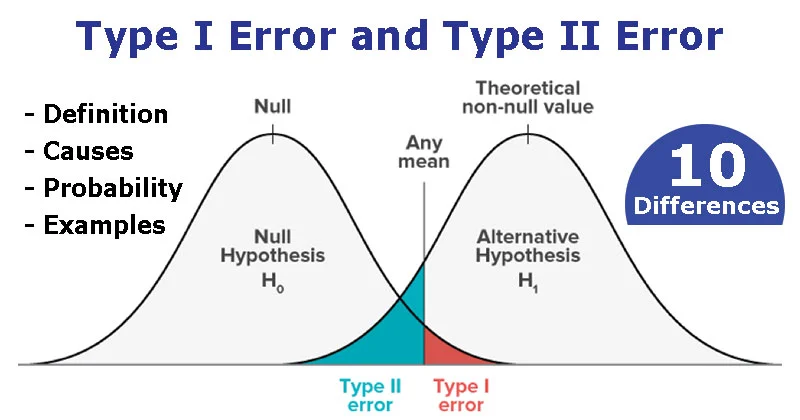

https://www.youtube.com/watch?v=vemZtEM63GY

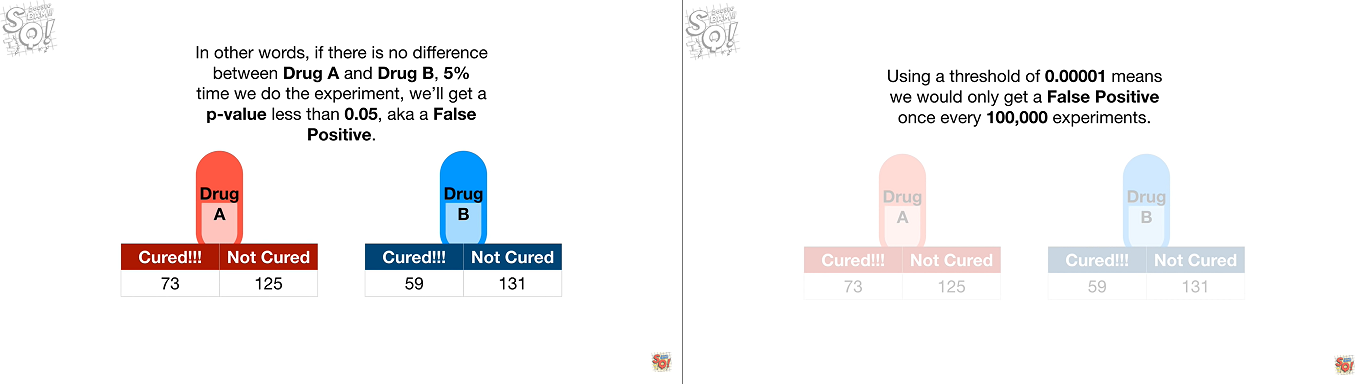

# **t-Tests**

There are numerous types of significance tests, depending on whether the data comprises count data or measured data, how many samples there are, and what’s being measured.

In [ ]:
res = stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time, 
                      session_times[session_times.Page == 'Page B'].Time,
                      equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}')

p-value for single sided test: 0.1408


In [ ]:
tstat, pvalue, df = sm.stats.ttest_ind(
    session_times[session_times.Page == 'Page A'].Time, 
    session_times[session_times.Page == 'Page B'].Time,
    usevar='unequal', alternative='smaller')
print(f'p-value: {pvalue:.4f}')

p-value: 0.1408


The alternative hypothesis is that the session time mean for page A is less than that for page B. The p-value of 0.1408 is fairly close to the permutation test p-values of 0.121

https://www.youtube.com/watch?v=NF5_btOaCig

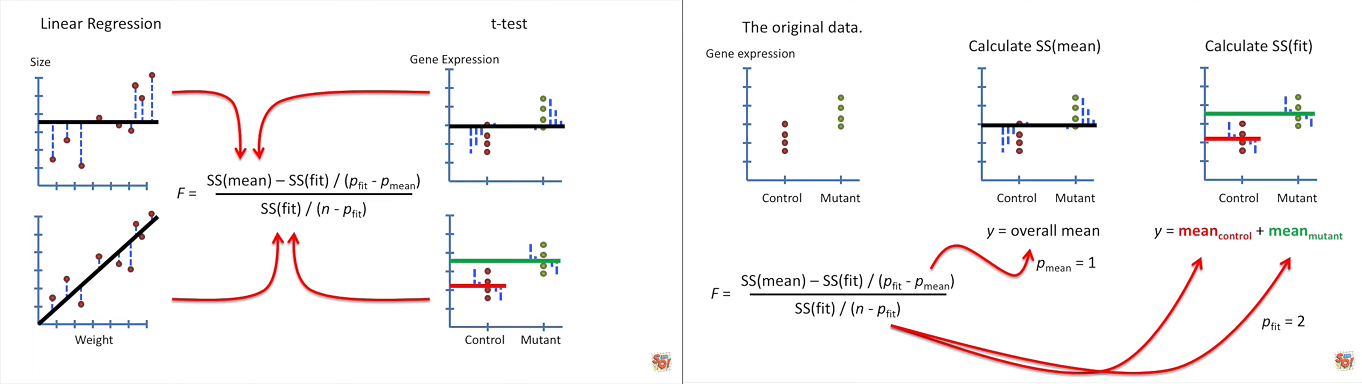

# **Multiple Testing**

https://xkcd.com/882/

* When we run a hypothesis test for a single question, we have a 95% chance of getting the right answer (a p-value > 0.05) — and a 5% chance of making a type I error.

* When we run hypothesis tests for two questions, we have only a 90% chance of getting the right answer for both hypothesis tests (.95*.95 = 0.90) — and a 10% chance of making at least one type I error.

### **p-hacking**

https://www.youtube.com/watch?v=Gx0fAjNHb1M&list=PLH2l6uzC4UEW3iJO4T0qUeUEp_X-f1U7S&index=31

https://www.youtube.com/watch?v=HDCOUXE3HMM

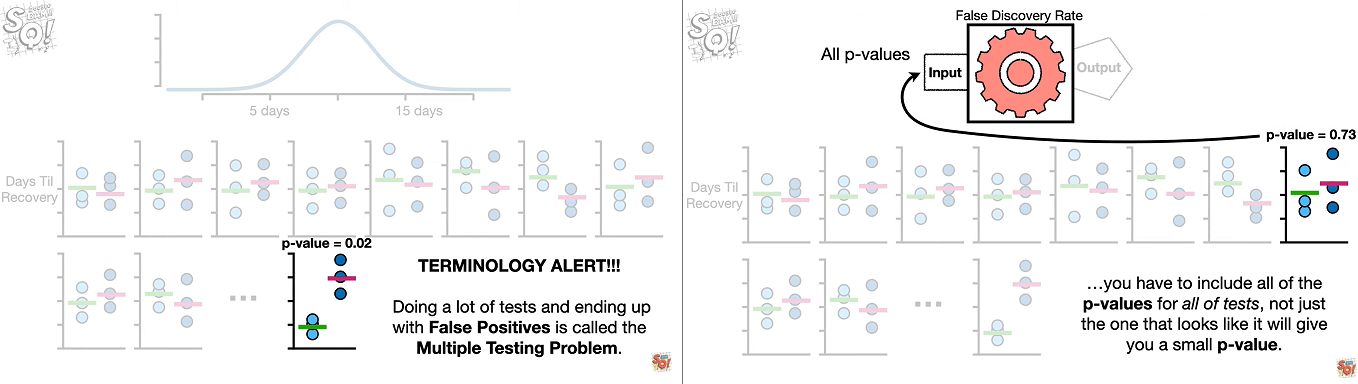


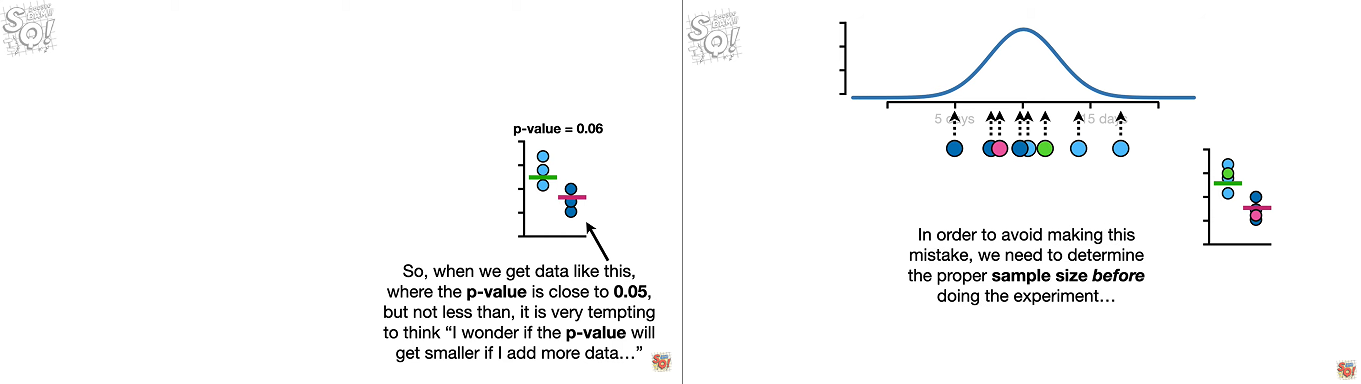

# **Degrees of freedom**

* the number of values free to vary (or the amount of independent information that you have)

* This most commonly occurs when
factoring categorical variables into binary indicators (dummies).

https://www.youtube.com/watch?v=Cm0vFoGVMB8&list=PL8dPuuaLjXtNM_Y-bUAhblSAdWRnmBUcr&index=29

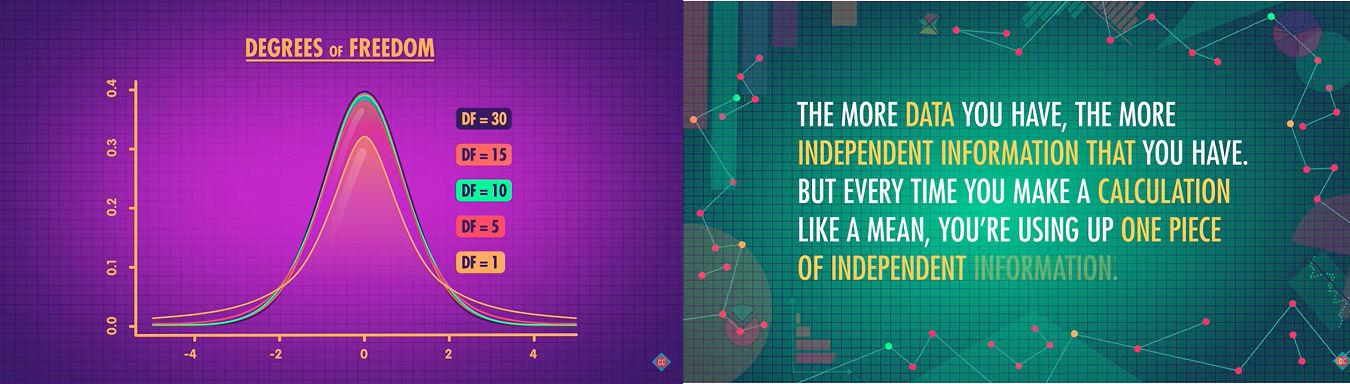

# **ANOVA**

comparison of multiple groups, say A/B/C/D, each with numeric data (avoid Multiple Testing)

|   |Page 1 | Page 2  | Page 3  | Page 4  |
|:-:|---|---|---|---|
|   | 164   | 178  | 175  | 155  |
|   | 172   | 191  | 193  | 166  |
|   | 177   | 182  | 171  | 164  |
|   | 156   | 185  | 163  | 170  |
|   | 195   | 177  | 176  | 168  |
| Average   | 172  | 185  | 176  | 162  |
| Grand average  |   |   |   | 173.75  |


“Could all the pages have the same underlying stickiness, and the differences among them be due to the random way in which a common set of session times got allocated among the four pages?”

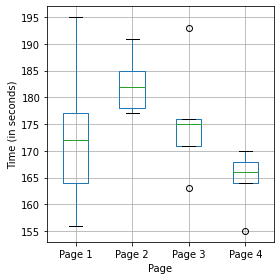

In [ ]:
four_sessions = pd.read_csv(FOUR_SESSIONS_CSV)

ax = four_sessions.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('Page')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')
plt.title('')

plt.tight_layout()
plt.show()

In [ ]:
print(pd.read_csv(FOUR_SESSIONS_CSV).head())

     Page  Time
0  Page 1   164
1  Page 2   178
2  Page 3   175
3  Page 4   155
4  Page 1   172


In [ ]:
observed_variance = four_sessions.groupby('Page').mean().var()[0]
print('Observed means:', four_sessions.groupby('Page').mean().values.ravel())
print('Variance:', observed_variance)
# Permutation test example with stickiness
def perm_test(df):
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var()[0]
    
print(perm_test(four_sessions))

Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655
8.89333333333337


1. Combine all the data together in a single box.
2. Shuffle and draw out four resamples of five values each.
3. Record the mean of each of the four groups.
4. Record the variance among the four group means.
5. Repeat steps 2–4 many (say, 3,000) times.

Pr(Prob) 0.084


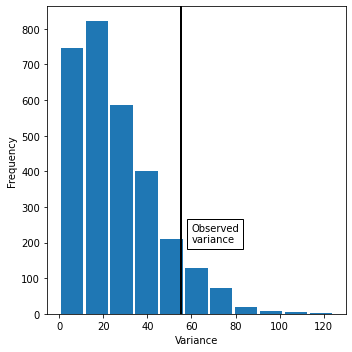

In [ ]:
random.seed(1)
perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_variance, bins=11, rwidth=0.9)
ax.axvline(x = observed_variance, color='black', lw=2)
ax.text(60, 200, 'Observed\nvariance', bbox={'facecolor':'white'})
ax.set_xlabel('Variance')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

The p-value, given by Pr(Prob), is 0.07233.

## **F-Statistic**

Just like the t-test can be used instead of a permutation test for comparing the mean of two groups, there is a statistical test for ANOVA based on the F-statistic (based on the ratio of the variance across group means)

In [ ]:
model = smf.ols('Time ~ Page', data=four_sessions).fit()
                
aov_table = sm.stats.anova_lm(model)
print(aov_table)

            df  sum_sq     mean_sq         F    PR(>F)
Page       3.0   831.4  277.133333  2.739825  0.077586
Residual  16.0  1618.4  101.150000       NaN       NaN


With scipy:

In [ ]:
res = stats.f_oneway(four_sessions[four_sessions.Page == 'Page 1'].Time, 
                     four_sessions[four_sessions.Page == 'Page 2'].Time,
                     four_sessions[four_sessions.Page == 'Page 3'].Time,
                     four_sessions[four_sessions.Page == 'Page 4'].Time)
print(f'F-Statistic: {res.statistic / 2:.4f}')
print(f'p-value: {res.pvalue / 2:.4f}')

F-Statistic: 1.3699
p-value: 0.0388


https://www.youtube.com/watch?v=oOuu8IBd-yo&list=PL8dPuuaLjXtNM_Y-bUAhblSAdWRnmBUcr&index=36

- Do ANOVA to reject Null Hypothesis
- Then do T-Test

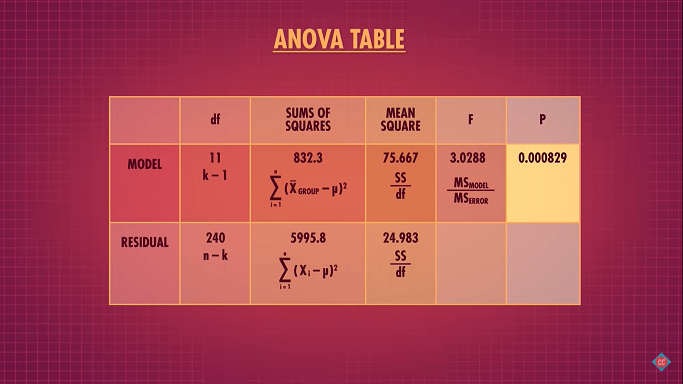

https://www.youtube.com/watch?v=NF5_btOaCig

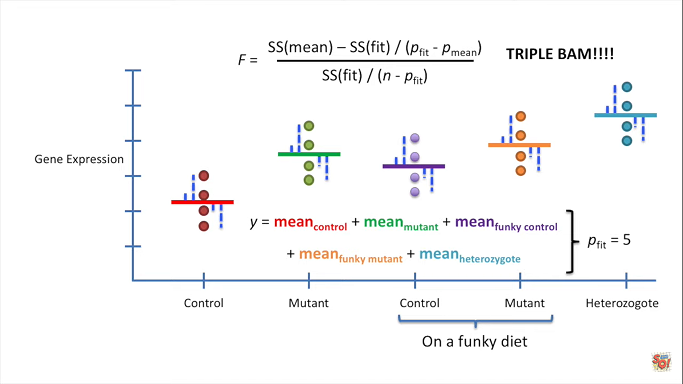

https://towardsdatascience.com/anova-for-feature-selection-in-machine-learning-d9305e228476

# **Chi-Square Test**

* The chi-square test is used with count data to test how well it fits some expected distribution (contingency tables)

* assess whether the null hypothesis of independence among variables is reasonable

https://machinelearningmastery.com/chi-squared-test-for-machine-learning/

## **Chi-Square Test: A Resampling Approach**

In [ ]:
click_rate = pd.read_csv(CLICK_RATE_CSV)
clicks = click_rate.pivot(index='Click', columns='Headline', values='Rate')
print(clicks)

Headline  Headline A  Headline B  Headline C
Click                                       
Click             14           8          12
No-click         986         992         988


A resampling procedure can test whether the click rates differ to an extent greater than chance might cause. For this test, we need to have the “expected” distribution of clicks, and in this case, that would be under the null hypothesis assumption that all three headlines share the same click
rate, for an overall click rate of 34/3,000.

In [ ]:
row_average = clicks.mean(axis=1)
pd.DataFrame({
    'Headline A': row_average,
    'Headline B': row_average,
    'Headline C': row_average,
})

Headline A  Headline B  Headline C
Click                                       
Click      11.333333   11.333333   11.333333
No-click  988.666667  988.666667  988.666667

1. Constitute a box with 34 ones (clicks) and 2,966 zeros (no clicks).
2. Shuffle, take three separate samples of 1,000, and count the clicks in each.
3. Find the squared differences between the shuffled counts and the expected
counts and sum them.
4. Repeat steps 2 and 3, say, 1,000 times.
5. How often does the resampled sum of squared deviations exceed the observed?
That’s the p-value.

In [ ]:
box = [1] * 34
box.extend([0] * 2966)
random.shuffle(box)

def chi2(observed, expected):
    pearson_residuals = []
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe - expect) ** 2 / expect
                                  for observe in row])
    # return sum of squares
    return np.sum(pearson_residuals)

expected_clicks = 34 / 3
expected_noclicks = 1000 - expected_clicks
expected = [34 / 3, 1000 - 34 / 3]
chi2observed = chi2(clicks.values, expected)

def perm_fun(box):
    sample_clicks = [sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000))]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

perm_chi2 = [perm_fun(box) for _ in range(2000)]

resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampled p-value: {resampled_p_value:.4f}')

Observed chi2: 1.6659
Resampled p-value: 0.4820


In [ ]:
chisq, pvalue, df, expected = stats.chi2_contingency(clicks)
print(f'Observed chi2: {chisq:.4f}')
print(f'p-value: {pvalue:.4f}')

Observed chi2: 1.6659
p-value: 0.4348


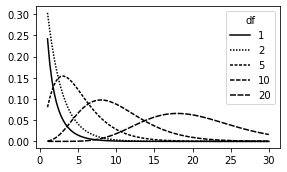

In [ ]:
x = [1 + i * (30 - 1) / 99 for i in range(100)]

chi = pd.DataFrame({
    'x': x,
    'chi_1': stats.chi2.pdf(x, df=1),
    'chi_2': stats.chi2.pdf(x, df=2),
    'chi_5': stats.chi2.pdf(x, df=5),
    'chi_10': stats.chi2.pdf(x, df=10),
    'chi_20': stats.chi2.pdf(x, df=20),
})
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.plot(chi.x, chi.chi_1, color='black', linestyle='-', label='1')
ax.plot(chi.x, chi.chi_2, color='black', linestyle=(0, (1, 1)), label='2')
ax.plot(chi.x, chi.chi_5, color='black', linestyle=(0, (2, 1)), label='5')
ax.plot(chi.x, chi.chi_10, color='black', linestyle=(0, (3, 1)), label='10')
ax.plot(chi.x, chi.chi_20, color='black', linestyle=(0, (4, 1)), label='20')
ax.legend(title='df')

plt.tight_layout()
plt.show()

degrees of freedom = (r − 1) × (c − 1)

## **Fisher’s Exact Test**
* Fisher's Exact test is used instead of a Pearson's Chi-squared test when you have a small sample, which is typically anything under 1,000 cases.
* There is no implementation of Fisher’s exact test easily available in Python.

In [ ]:
stats.fisher_exact(clicks.loc[['Click', 'No-click'], ['Headline A', 'Headline B']])

(1.7606490872210954, 0.2835969483984848)

## **Detecting Scientic Fraud**

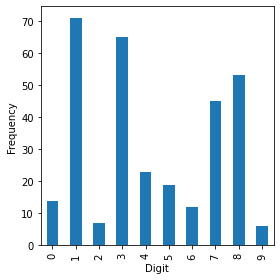

In [ ]:
imanishi = pd.read_csv(IMANISHI_CSV)
imanishi.columns = [c.strip() for c in imanishi.columns]
ax = imanishi.plot.bar(x='Digit', y=['Frequency'], legend=False,
                      figsize=(4, 4))
ax.set_xlabel('Digit')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
chisq, pvalue, df, expected = stats.chi2_contingency(imanishi)
print(f'Observed chi2: {chisq:.4f}')
print(f'p-value: {pvalue:.4f}')

Observed chi2: 54.7788
p-value: 0.0000


# **Multi-Arm Bandit Algorithm**

https://www.youtube.com/watch?v=bkw6hWvh_3k

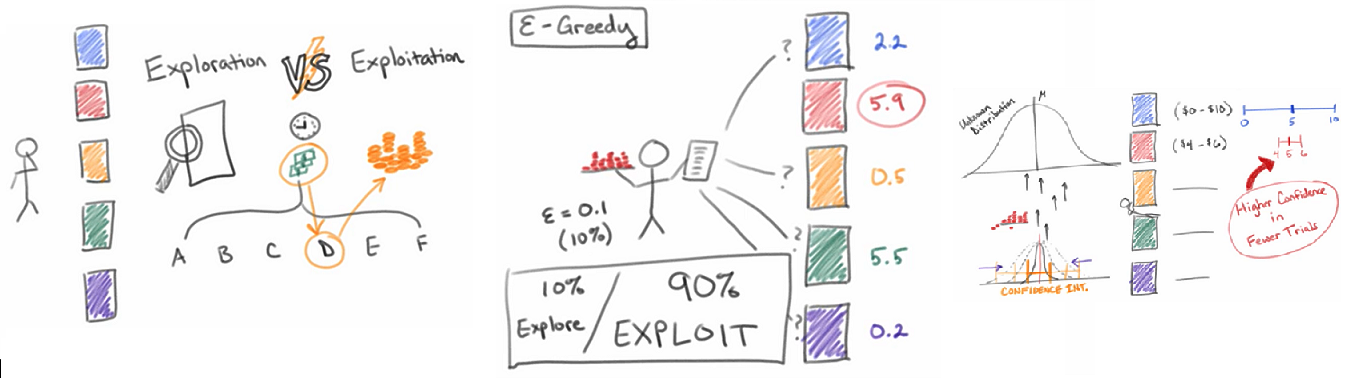

# **Power and Sample Size**

If you run a web test, how do you decide how long it should run?

* Power is the probability of detecting a specified effect size with specified sample characteristics (size and variability).
* Power of Hypothesis Test is a probability of not committing the Type II error
* “effect size” drives the sample size (more effect size, less sample size)

Source: https://www.youtube.com/watch?v=WWagtGT1zH4&list=PLH2l6uzC4UEW3iJO4T0qUeUEp_X-f1U7S&index=24

How to less overlap the 2 distribution to increase statistical power? 
Effect Size! Make ths distribution skinner (increase sample size)

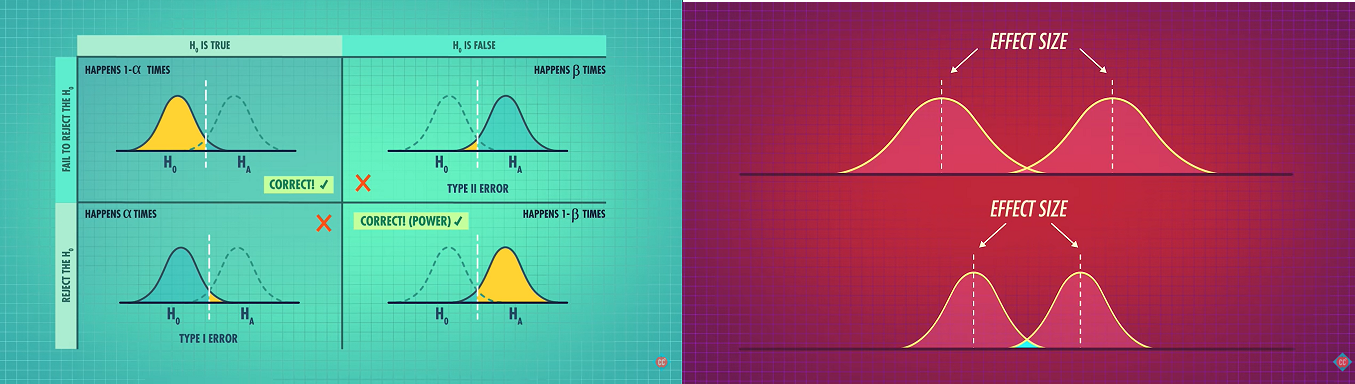



How big the effect compared with random variation?

https://www.youtube.com/watch?v=Cm0vFoGVMB8&list=PL8dPuuaLjXtNM_Y-bUAhblSAdWRnmBUcr&index=29

For example, suppose current click-through rates are about 1.1%, and you are seeking a 10% boost (effect size) to 1.21%. So, we have two boxes: 
* box A with 1.1% ones (say, 110 ones and 9,890 zeros)
* and box B with 1.21% ones (say, 121 ones and 9,879 zeros)

In [ ]:
effect_size = sm.stats.proportion_effectsize(0.0121, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 116602.393


We see that if we want a power of 80%, we require a sample size of almost 120,000 impressions.

In [ ]:
effect_size = sm.stats.proportion_effectsize(0.0165, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 5488.408


If we are seeking a 50% boost (p1=0.0165), the sample size is reduced to 5,500 impressions.

Designing experiments:
* sample size
* minimum effect size
* power (probability of detecting that effect size)
* alpha (significance level)

# **Extra**

Statistical Power: used in binary hypothesis testing (more sample size => high statistical power)

Source: https://www.youtube.com/watch?v=Rsc5znwR5FA

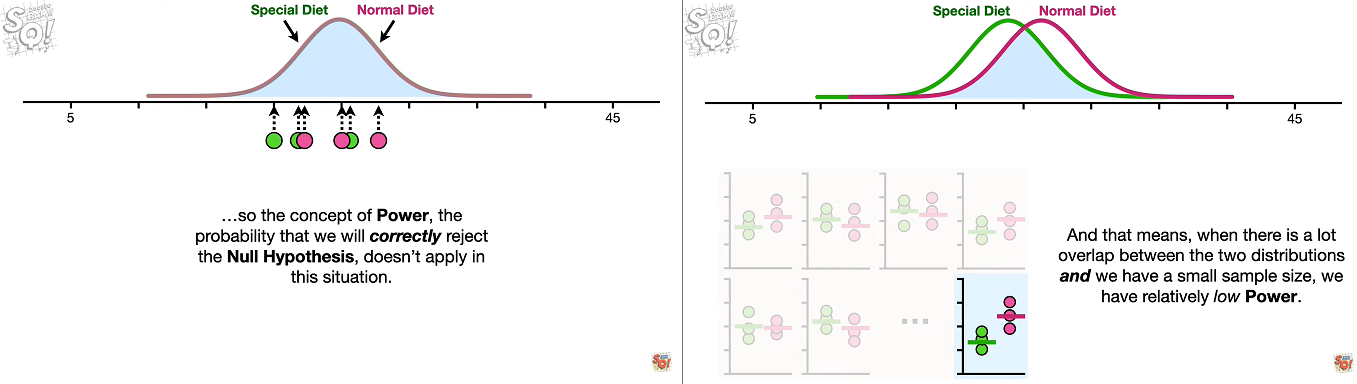

https://www.youtube.com/watch?v=IY7y-t30UJc

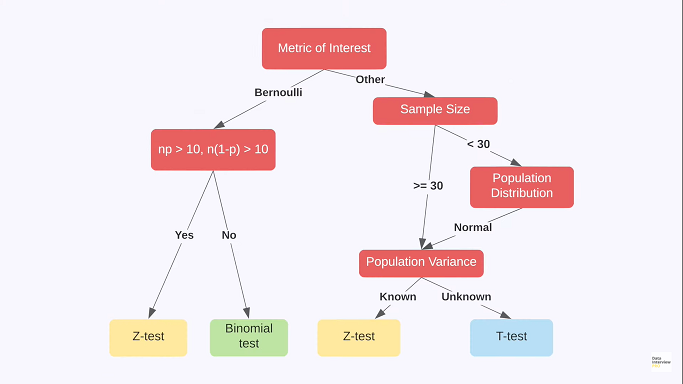

**Select model using hypothesis tests**

https://machinelearningmastery.com/statistical-significance-tests-for-comparing-machine-learning-algorithms/

Interview questions:

https://towardsdatascience.com/40-statistics-interview-problems-and-answers-for-data-scientists-6971a02b7eee

**Binomial tests** are similar to one-sample t-tests in that they test a sample statistic against some population-level expectation. The difference is that:

* binomial tests are used for binary categorical data to compare a sample frequency to an expected population-level probability
* one-sample t-tests are used for quantitative data to compare a sample mean to an expected population mean.